# Skies in DR7.1

A quick look at sky targets in DR7.1.

John Moustakas  
2018 Aug 21

In [1]:
import os
import numpy as np
import fitsio
from astropy.table import Table

In [2]:
from desitarget.targetmask import desi_mask

In [3]:
import matplotlib.pyplot as plt

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [5]:
skyfile = os.path.join(os.getenv('DESI_ROOT'), 'target', 'catalogs', 
                       'dr7.1', '0.22.0', 'skies-dr7.1-0.22.0.fits')
sky = Table(fitsio.read(skyfile))
print('Read {} skies from {}'.format(len(sky), skyfile))

Read 25936848 skies from /global/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/skies-dr7.1-0.22.0.fits


In [6]:
skyhdr = fitsio.read_header(skyfile, ext=1)
print('Aperture_0 = {}, aperture_1 = {} arcsec'.format(skyhdr['AP0'], skyhdr['AP1']))

Aperture_0 = 0.75, aperture_1 = 1.0 arcsec


In [7]:
sky.colnames

['RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'RA',
 'DEC',
 'APFLUX_G',
 'APFLUX_R',
 'APFLUX_Z',
 'APFLUX_IVAR_G',
 'APFLUX_IVAR_R',
 'APFLUX_IVAR_Z',
 'OBSCONDITIONS',
 'SUBPRIORITY',
 'TARGETID',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'HPXPIXEL']

Mean g=29.937
Mean r=29.681
Mean z=28.111


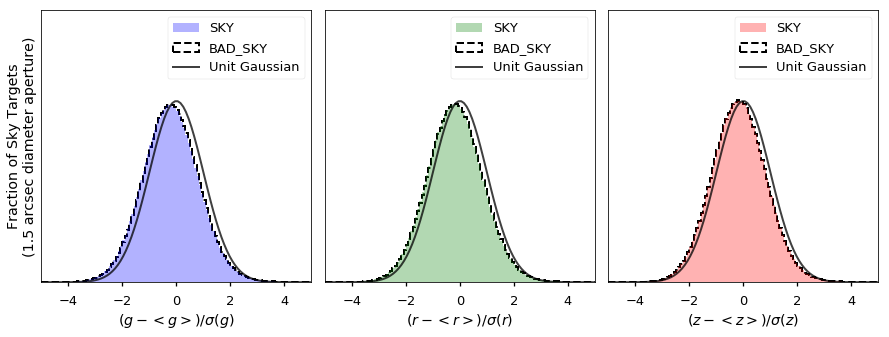

In [8]:
nbin = 120
xlim = (-0.2, 0.2)
xlim = (-5, 5)
xgauss = np.linspace(-5, 5, 100)

def gauss(xx, mu, sig):
    return np.exp(-np.power(xx - mu, 2.) / (2 * np.power(sig, 2.)))

col = ('blue', 'green', 'red')
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for ii, band in enumerate(('G', 'R', 'Z')):
    filt = band.lower()
    
    good = np.where( (sky['TARGETID'] & desi_mask['SKY'] != 0) *
                     (sky['APFLUX_{}'.format(band)][:, 0].data != 0) *
                     (sky['APFLUX_IVAR_{}'.format(band)][:, 0].data != 0) 
                   )[0]
    bad = np.where( (sky['TARGETID'] & desi_mask['BAD_SKY'] != 0) *
                    (sky['APFLUX_{}'.format(band)][:, 0].data != 0) *
                    (sky['APFLUX_IVAR_{}'.format(band)][:, 0].data != 0) 
                  )[0]
    
    goodflux = sky['APFLUX_{}'.format(band)][good, 0].data
    goodivar = sky['APFLUX_IVAR_{}'.format(band)][good, 0].data
    #gnotzero = goodflux != 0.0
    
    badflux = sky['APFLUX_{}'.format(band)][bad, 0].data
    badivar = sky['APFLUX_IVAR_{}'.format(band)][bad, 0].data
    #bnotzero = badflux != 0.0
    
    gflux = (goodflux - np.mean(goodflux)) * np.sqrt(goodivar)
    bflux = (badflux - np.mean(badflux)) * np.sqrt(badivar)
    #wavg = 22.5 - 2.5 * np.log10(np.average(goodflux, weights=goodivar))
    wavg = 22.5 - 2.5 * np.log10(np.mean(goodflux))
    print('Mean {}={:.3f}'.format(filt, wavg))
    #import pdb ; pdb.set_trace()

    ax[ii].hist(bflux, bins=nbin, label='BAD_SKY', color='k', 
                ls='--', lw=2, histtype='step', range=xlim, normed=True)
    ax[ii].hist(gflux, bins=nbin, label='SKY', alpha=0.3,
                color=col[ii], range=xlim, normed=True)
    ygauss = gauss(xgauss, 0.0, 1.0)
    ax[ii].plot(xgauss, 0.4*ygauss, lw=2, color='k', 
                ls='-', alpha=0.75, label='Unit Gaussian')
    
    #ax[ii].legend(loc='upper right')
    hh, ll = ax[ii].get_legend_handles_labels()
    ax[ii].legend(hh[::-1], ll[::-1], loc='upper right')
    
    ax[ii].set_xlim(xlim)
    ax[ii].set_ylim(0, 0.6)

    ax[ii].axes.get_yaxis().set_ticks([])
    ax[ii].set_xlabel('$({}-<{}>)/\sigma({})$'.format(filt, filt, filt))
    
ax[0].set_ylabel('Fraction of Sky Targets\n(1.5 arcsec diameter aperture)')
#ax[0].legend(loc='upper right')
fig.subplots_adjust(wspace=0.05)